In [1]:
from envs.train_env import Electric_Car
from models.baseline import BaselineModel
from models.baseline2 import BaselineModel2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from models.tabular_qlearning import TabularQLearning
from envs.feature_engineering import DataHelper
import torch
import matplotlib.patches as mpatches

In [2]:
def data_analysis():
    data_path_train = 'data/train.xlsx'
    df = pd.read_excel(data_path_train)

    df['Month'] = df['PRICES'].dt.month
    df['DayOfWeek'] = df['PRICES'].dt.dayofweek
    df['AvgPerDay'] = df.iloc[:, 1:25].mean(axis=1)

    monthly_avg = df.groupby('Month')['AvgPerDay'].mean()
    day_of_week_avg = df.groupby('DayOfWeek')['AvgPerDay'].mean()
    hourly_avg = df.iloc[:, 1:25].mean()

    monthly_avg.plot(kind='bar', title='Average Price per Month',edgecolor='black')
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.show()

    day_of_week_avg.plot(kind='bar', title='Average Price per Day of the Week',edgecolor='black')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Price')
    plt.show()

    hourly_avg.plot(kind='bar', title='Average Price per Hour',edgecolor='black')
    plt.xlabel('Hour')
    plt.ylabel('Average Price')
    plt.show()


In [3]:
def plot(actions, rewards, states, infos, max = 400):
    batteries = np.array(states)[:, 0]
    prices = np.array(states)[:, 1]
    x = range(len(prices))
    hours = np.array(states)[:, 2]


    #The following code creates boolean arrays indicating what the final action is we take, forced buying happens when we do not have 20KwH at 7AM
    #Needed for colour coding scatter plots conditionally
    buying = np.full(len(batteries), False, dtype=bool)
    selling = np.full(len(batteries), False, dtype=bool)
    forced_charging = np.full(len(batteries), False, dtype=bool)
    for i in range(len(batteries - 1)):
        if actions[i] > 0 and infos[i] > 0:
            buying[i] = True
        elif infos[i] > 0:
            forced_charging[i] = True
        elif infos[i] < 0:
            selling[i] = True


    #Plotting the prices with the actions
    plt.figure(figsize=(12, 6))
    plt.ylim(0, 300)
    plt.xlim(0, max)
    col = np.where(forced_charging,'darkred', np.where(buying, 'red', np.where(selling, 'green', '#FF000000')))
    plt.scatter(x, prices, c = col,s = 30, zorder=1)
    plt.plot(x, prices, zorder =0, alpha=0.8)
    plt.ylabel('Price in Euro')
    plt.xlabel('Time')
    custom_legend = [
            mpatches.Patch(color='green', label='Selling'),
            mpatches.Patch(color='red', label='Buying'),
            mpatches.Patch(color='darkred', label='Forced Charging')
            ]
    plt.legend(handles=custom_legend)
    plt.title('Price and Policy')
    plt.show()


    #The following code creates arrays between timestamps indicating the action taken
    #Needed to make linecharts with conditional colours
    f = np.array([False])
    prev_fc = np.concatenate((f, forced_charging[:-1]), dtype = bool)
    prev_buy = np.concatenate((f, buying[:-1]), dtype = bool)
    prev_sell = np.concatenate((f, selling[:-1]), dtype = bool)
    prev_fc = np.logical_or(forced_charging, prev_fc)
    prev_buy = np.logical_or(buying, prev_buy)
    prev_sell = np.logical_or(selling, prev_sell)
    fc = batteries.copy()
    buy = batteries.copy()
    sell = batteries.copy()
    for i in range (len(batteries)):
        if prev_fc[i] == False:
            fc[i] = None
        if prev_buy[i] == False:
            buy[i] = None
        if prev_sell[i] == False:
            sell[i] = None


    #Plotting the Battery and actions
    plt.figure(figsize=(12, 6))
    plt.ylim(0, 55)
    plt.xlim(0, max)
    col = np.where(forced_charging,'darkred', np.where(buying, 'red', np.where(selling, 'green', '#FF000000')))
    plt.scatter(x, batteries, c = col, s = 30, zorder=1)
    plt.plot(x, batteries, zorder = 0)
    plt.plot(x, buy, alpha=0.8, c = 'red', zorder =1)
    plt.plot(x, sell, alpha=0.8, c = 'green', zorder =1)
    plt.plot(x, fc, alpha = 0.8, c = 'darkred', zorder = 1, label='Battery and actions')
    plt.ylabel('Battery')
    plt.xlabel('Time')
    plt.legend(handles=custom_legend)
    plt.title('Battery and Policy')
    plt.show()

    plt.figure(figsize=(12,6))
    hours_forced = np.zeros(24)
    hours_buying = np.zeros(24)
    hours_selling = np.zeros(24)
    for i in range(len(batteries)):
        if forced_charging[i] == True:
            hours_forced[int(hours[i])-1] += 1
        if buying[i] == True:
            hours_buying[int(hours[i])-1] += 1
        if selling[i] == True:
            hours_selling[int(hours[i])-1] += 1

    barWidth = 0.3
    xpos = np.arange(len(hours_forced))
    plt.bar(xpos+1.3, hours_forced, width = barWidth, color="darkred", label = 'Forced Charging')
    plt.bar(xpos+1, hours_buying, width = barWidth,  color="red", label = 'Buying')
    plt.bar(xpos+0.7, hours_selling, width = barWidth,  color="green", label = 'selling')
    plt.xticks(xpos+1)
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel('Count of Actions')
    plt.title('Actions per Hour')
    plt.show()

    #Plotting the cumlative reward in given timeframe
    plt.figure(figsize=(12, 6))
    cum_rewards = np.cumsum(np.array(rewards))
    plt.xlim(0, max)
    plt.ylim(-100, 10)
    plt.plot(x, cum_rewards, label = 'Cumulative Rewards')
    plt.xlabel('Time')
    plt.ylabel('Profit in Euro')
    plt.title('Cumulative rewards up to t =%i' %max)
    plt.show()


    #Plotting the Total Cumulative Reward
    plt.figure(figsize=(12, 6))
    cum_rewards = np.cumsum(np.array(rewards))
    plt.plot(x, cum_rewards)
    plt.title('Total Cumulative Rewards | Value = %.2f' % sum(rewards))
    plt.xlabel('Time')
    plt.ylabel('Profit in Euro')
    plt.show()

    return

In [4]:
def plot_updates_Qtable(Qtable_updates, features):
    ''' 
    Plots the number of updates of the Qtable for every dimension
    '''
    for i in range(len(features)):
        axes = list(range(len(features)+1))
        axes.remove(axes[i])
        sums = np.sum(Qtable_updates, axis=tuple(axes))
        plt.bar(range(len(sums)), sums, color='green', edgecolor='black')
        plt.title('Sum of updates per cell of feature %d'%features[i])
        plt.show()
    return

In [5]:
def plot_best_worst(rewards, states, infos):
    # Get data of the best and worst 1000 actions
    copied_list = rewards.copy()
    sorted_idx = sorted(range(len(copied_list)), key=lambda k: copied_list[k], reverse=True)
    best = [[],[],[],[],[],[]]
    worst = [[],[],[],[],[],[]]

    print('\nActions highest rewards')
    for j in range(1000):
        i = sorted_idx[j]
        best[0].append(states[i][0])
        best[1].append(states[i][1])
        best[2].append(states[i][2])
        best[3].append(states[i][3])
        best[4].append(states[i][5])
        best[5].append(rewards[i])

        if j < 20:
            print('\nbattery',int(states[i][0]), '  price',int(states[i][1]), '  hour',int(states[i][2]),'  day_of_week',int(states[i][3]),'  month',int(states[i][5]), '  availability',int(states[i][7]))
            print('action',infos[i])
            print('reward',rewards[i])

    plt.hist(best[0], bins=20)
    plt.title('battery')
    plt.show()
    plt.hist(best[1], bins=20)
    plt.title('price')
    plt.show()
    plt.hist(best[2], bins=24)
    plt.title('hour')
    plt.show()
    plt.hist(best[3], bins=7)
    plt.title('day of wek')
    plt.show()
    plt.hist(best[4], bins=12)
    plt.title('month')
    plt.show()
    plt.hist(best[5], bins=20)
    plt.title('reward')
    plt.show()

    print('Actions lowest rewards')
    for j in range(1, 1001):
        i = sorted_idx[-j]
        worst[0].append(states[i][0])
        worst[1].append(states[i][1])
        worst[2].append(states[i][2])
        worst[3].append(states[i][3])
        worst[4].append(states[i][5])
        worst[5].append(rewards[i])

        if j < 21:
            print('\nbattery',int(states[i][0]), '  price',int(states[i][1]), '  hour',int(states[i][2]),'  day_of_week',int(states[i][3]), '  day_of_year',int(states[i][4]),'  month',int(states[i][5]), '  availability',int(states[i][7]))
            print('action',infos[i])
            print('reward',rewards[i])

    plt.hist(worst[0], bins=20)
    plt.title('battery')
    plt.show()
    plt.hist(worst[1], bins=20)
    plt.title('price')
    plt.show()
    plt.hist(worst[2], bins=24)
    plt.title('hour')
    plt.show()
    plt.hist(worst[3], bins=7)
    plt.title('day of week')
    plt.show()
    plt.hist(worst[4], bins=12)
    plt.title('month')
    plt.show()
    plt.hist(worst[5], bins=20)
    plt.title('reward')
    plt.show()
    
    return

Please wait, the algorithm is learning! The current simulation is 0
Average reward  -40953.04066082034
Please wait, the algorithm is learning! The current simulation is 1
Average reward  -35000.53395785981
Please wait, the algorithm is learning! The current simulation is 2
Average reward  -30699.335799606408
Please wait, the algorithm is learning! The current simulation is 3
Average reward  -24101.728594195414
Please wait, the algorithm is learning! The current simulation is 4
Average reward  -19514.058372360105
Please wait, the algorithm is learning! The current simulation is 5
Average reward  -16181.775773555188
Please wait, the algorithm is learning! The current simulation is 6
Average reward  -13460.948577779549
Please wait, the algorithm is learning! The current simulation is 7
Average reward  -8300.205611950878
Please wait, the algorithm is learning! The current simulation is 8
Average reward  -5446.742391720348
Please wait, the algorithm is learning! The current simulation is 9


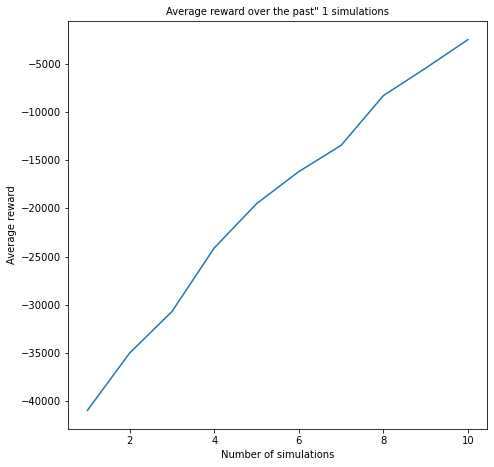

In [7]:
data_path_train = 'data/train.xlsx'
data_path_test = 'data/validate.xlsx'

simulations = 10
simulations_per_average = simulations/10
learning_rate = 0.1
epsilon = 0.05
epsilon_decay = simulations
adaptive_epsilon = True
adapting_learning_rate = False  # can ensure a more stable policy when simulations is high
discount_rate = 0.99            # 0.99 is too high, should be between 0.95-0.98

# 0 battery, 1 price, 2 hour, 3 day of week, 5 month
features_Qtable = [0, 1, 2, 3, 5] 

# binsize of features with corresponding index to features_Qtable, last value is for action space
# bin_size is the state space + 1
bin_size = [4, 6, 7, 3, 4, 4]     

model = TabularQLearning(data_path_train, discount_rate, bin_size, features_Qtable)
model.train(simulations, simulations_per_average, learning_rate, epsilon, epsilon_decay, adaptive_epsilon, adapting_learning_rate)
model.visualize_rewards_and_performance()

#model.create_Q_table()
#model.load_Qtable('model_checkpoints/Tabular1.npy')
#model.save_Qtable('test.npy')

Revenue -521.1997386419758
Revenue -549.2133388271612
Revenue -540.6374439506178
Revenue -481.56006388888983
Revenue -556.8242191975313
Average total revenue  -529.8869609012352


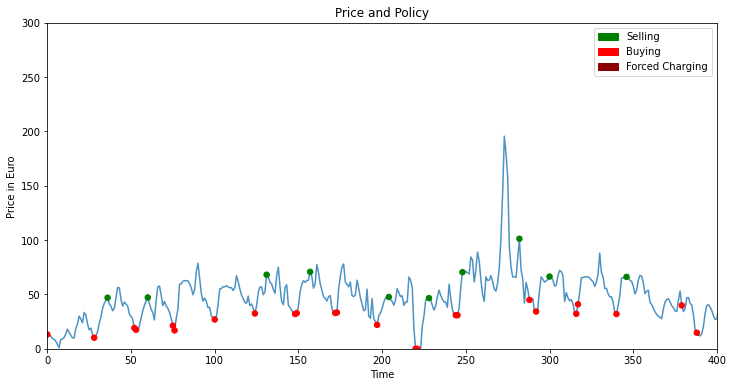

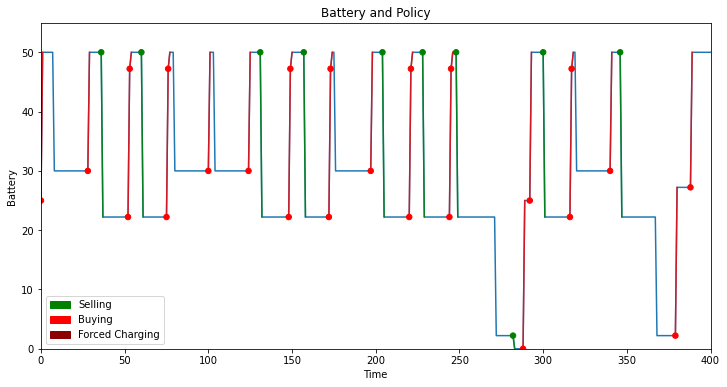

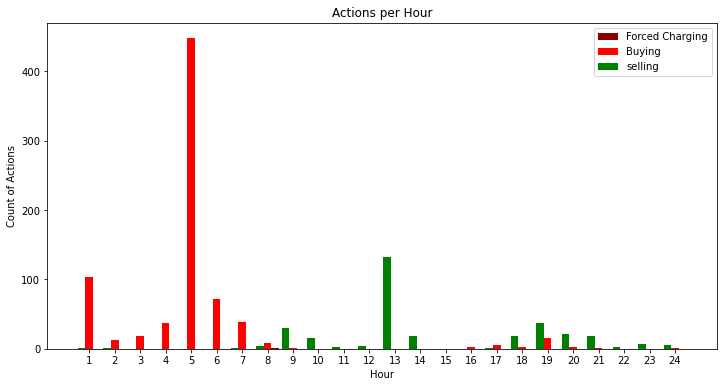

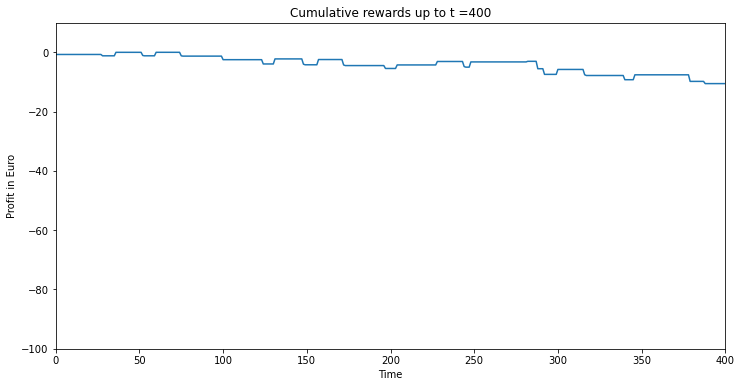

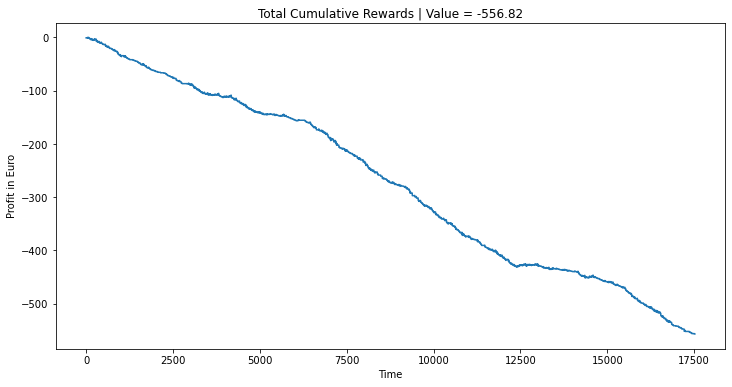

In [15]:
number_of_rollouts = 5
sum_total_revenues = 0

for i in range(number_of_rollouts):
    actions, rewards, states, infos = model.play(data_path_test)
    print('Revenue', sum(rewards))
    sum_total_revenues+=sum(rewards)
    #plot_updates_Qtable(model.Qtable_updates, features_Qtable)
    #plot_best_worst(rewards, states, infos)
    if i == number_of_rollouts-1:
        print('Average total revenue ', sum_total_revenues/number_of_rollouts)
        plot(actions, rewards, states, infos)